In [6]:
!unzip asl_dataset.zip

Archive:  asl_dataset.zip
replace asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [9]:
#Selecting dataset directory

ds_asl_dir = "/content/asl_dataset"

#Generating a dataset

asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

Found 2515 files belonging to 36 classes.


In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

#Listing directory. You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

!ls "/content/asl_dataset"

#Showing index + class

pd.DataFrame(asl_ds.class_names)

0  2  4  6  8  a  c  e	g  i  k  m  o  q  s  u	w  y
1  3  5  7  9  b  d  f	h  j  l  n  p  r  t  v	x  z


,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [11]:
for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [12]:
#Displaying some picture´s size

from PIL import Image
img =  Image.open("/content/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

Image sample with width=400 and height=400.


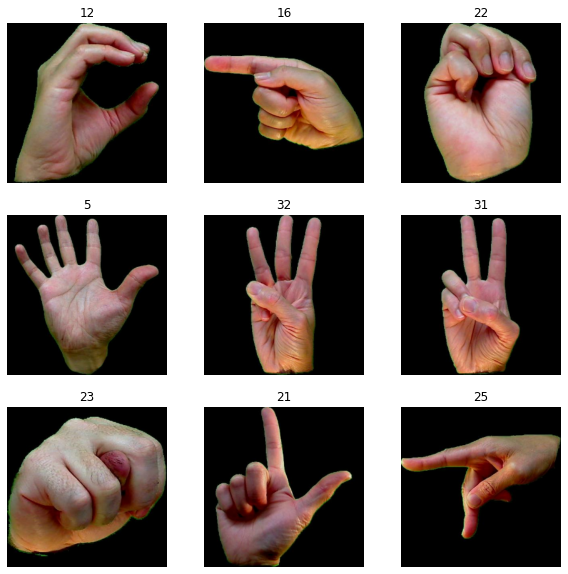

In [13]:
#Displaying image samples

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split
asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [15]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

In [16]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_acc",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=40)

Epoch 1/40
63/63 [==============================] - 16s 246ms/step - loss: 3.5199 - accuracy: 0.0457 - val_loss: 3.2525 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 16s 254ms/step - loss: 2.9420 - accuracy: 0.1397 - val_loss: 2.4579 - val_accuracy: 0.2584 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 15s 239ms/step - loss: 2.3665 - accuracy: 0.2619 - val_loss: 1.9505 - val_accuracy: 0.4195 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 15s 237ms/step - loss: 2.0236 - accuracy: 0.3459 - val_loss: 1.6113 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 15s 238ms/step - loss: 1.7343 - accuracy: 0.4160 - val_loss: 1.4067 - val_accuracy: 0.5368 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 16s 254ms/step - loss: 1.5604 - accuracy: 0.4791 - val_loss: 1.2833 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 15s 238ms/st

In [17]:
#Saving the model

model_dl.save("model_dl.h5")

#Loading themodel

model_dl = keras.models.load_model("model_dl.h5") #look for local saved file

In [64]:
from keras.preprocessing import image

#Creating a dictionary to map each of the indexes to the corresponding number or letter

dict1 = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",17:"h",18:"i",19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",28:"s",29:"t",30:"u",31:"v",32:"w",33:"x",34:"y",35:"z"}

#Predicting images

img = image.load_img("/content/asl_dataset/a/hand1_a_bot_seg_1_cropped.jpeg", target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model_dl.predict(image, batch_size=batch_size)
probabilities = model_dl.predict(image, batch_size=batch_size)
probabilities_formatted = list(map("{:.2f}%".format, probabilities[0]*100))

print(classes) #displaying matrix prediction position
np.argmax(classes)
print("The class the input image belongs to is:",dict1[np.argmax(classes)])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
The class the input image belongs to is: a
